In [1]:
import os
import numpy as np
from tqdm import tqdm
import torch
import torch.nn as nn
from torchvision.models import vgg16
from HSI_class import HSI
from datetime import datetime
import zeroPadding


In [4]:
datasets_path = r"/home/wijayanti/Desktop/FathanAbi/TA/tugas-akhir-model-deteksi-tumpahan-minyakl/Dataset/Hyperspectral oil spill detection datasets"

datasets = []
dataset_path = []

i = 0
for filename in os.listdir(datasets_path):
    if i>2:
        break
    file_path = os.path.join(datasets_path, filename)
    dataset_path.append(file_path)

dataset_path = sorted(dataset_path)

for path in dataset_path:
    print(path)

for file in dataset_path:
    if os.path.isfile(file):  # Check if it's a file
        print(f"Processing file: {file}")
        hsi = HSI(file)
        datasets.append(hsi)
    i += 1

/home/wijayanti/Desktop/FathanAbi/TA/tugas-akhir-model-deteksi-tumpahan-minyakl/Dataset/Hyperspectral oil spill detection datasets/.ipynb_checkpoints
/home/wijayanti/Desktop/FathanAbi/TA/tugas-akhir-model-deteksi-tumpahan-minyakl/Dataset/Hyperspectral oil spill detection datasets/GM01.mat
/home/wijayanti/Desktop/FathanAbi/TA/tugas-akhir-model-deteksi-tumpahan-minyakl/Dataset/Hyperspectral oil spill detection datasets/GM02.mat
/home/wijayanti/Desktop/FathanAbi/TA/tugas-akhir-model-deteksi-tumpahan-minyakl/Dataset/Hyperspectral oil spill detection datasets/GM03.mat
/home/wijayanti/Desktop/FathanAbi/TA/tugas-akhir-model-deteksi-tumpahan-minyakl/Dataset/Hyperspectral oil spill detection datasets/GM04.mat
/home/wijayanti/Desktop/FathanAbi/TA/tugas-akhir-model-deteksi-tumpahan-minyakl/Dataset/Hyperspectral oil spill detection datasets/GM05.mat
/home/wijayanti/Desktop/FathanAbi/TA/tugas-akhir-model-deteksi-tumpahan-minyakl/Dataset/Hyperspectral oil spill detection datasets/GM06.mat
/home/wija

In [5]:
def testWithDataset(n): 
    hsi_test = datasets[n]

    test_img = hsi_test.img
    gt= hsi_test.gt

    patch_size = 9
    half_patch = patch_size // 2

    height = test_img.shape[0]
    width = test_img.shape[1]

    matrix=zeroPadding.zeroPadding_3D(test_img,half_patch) #add 0 in every side of the data
    print(f"img shape: {test_img.shape}")
    print(f"img shape after padding {matrix.shape}")
    print(f"number of pixel {width * height}")

    print(f"ground truth shape: {gt.shape}")

    indices0 = np.argwhere(gt == 0)
    indices1 = np.argwhere(gt == 1)

    print(f"indices = 0 shape: {indices0.shape}")
    print(f"indices = 1 shape: {indices1.shape}")

    return matrix, gt

In [6]:
class VGG16_HSI(nn.Module):
    def __init__(self, num_classes=2):
        super(VGG16_HSI, self).__init__()

         # Custom Convolutional Layer: Process 9x9x224 input
        self.pre_conv = nn.Sequential(
            nn.Conv2d(in_channels=224, out_channels=128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(256),
            nn.AdaptiveAvgPool2d((1, 1))  # Reduce to (256, 1, 1)
        )

        # Fully Connected Layer to reshape to (64, 56, 56)
        self.fc = nn.Linear(256 * 1 * 1, 64 * 56 * 56)

        # Load VGG-16 Model
        self.encoder = vgg16(pretrained=False)

        # Remove first VGG-16 conv layer
        self.encoder.features = nn.Sequential(*list(self.encoder.features.children())[1:])

        # Modify classifier to output 2 classes
        self.encoder.classifier[6] = nn.Linear(4096, 2)

    def forward(self, x):
        # print(f'before {x.shape}')
        x = self.pre_conv(x)  # Process hyperspectral input
        x = x.view(x.size(0), -1)  # Flatten

        # print(f'after preconv {x.shape}')
        x = self.fc(x)  # Fully connected layer
        # print(f'after fc {x.shape}')
        # Reshape to (batch_size, 64, 56, 56) before passing to VGG
        x = x.view(x.size(0), 64, 56, 56)
        # print(f'after reshape, before vgg second layer {x.shape}')

        x = self.encoder.features(x)  # Pass to VGG-16
        x = self.encoder.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.encoder.classifier(x)  # Final classification layer

        return x

In [7]:
def predict_batch(model, batch_input, device):
    model.eval()
    batch_input = batch_input.to(device)

    with torch.no_grad():
        output = model(batch_input)

    predicted_classes = torch.argmax(output, dim=1).cpu().numpy()
    confidences = torch.nn.functional.softmax(output, dim=1)
    confidences = confidences[range(len(predicted_classes)), predicted_classes].cpu().numpy()

    return predicted_classes, confidences

In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
batch_size = 64  # You can change this depending on your GPU capacity

model_path = r"/home/wijayanti/Desktop/FathanAbi/TA/tugas-akhir-model-deteksi-tumpahan-minyakl/simsiam/simsiam/models/finetune/20250526_132806_model.pth.tar"
model_name = model_path.split('/')[-1]

print(f"Creating model {model_name}...")
saved_model = VGG16_HSI().to(device)
checkpoint = torch.load(model_path, map_location=device)
saved_model.load_state_dict(checkpoint['state_dict'])
print("Model loaded and moved to device")


Creating model 20250526_132806_model.pth.tar...


/home/wijayanti/anaconda3/envs/TAFathan/lib/python3.13/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/wijayanti/anaconda3/envs/TAFathan/lib/python3.13/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Model loaded and moved to device


In [9]:
from torch.utils.data import Dataset, DataLoader

# class CustomDataset(Dataset):
#     def __init__(self, matrix):
#         """
#         Args:
#             images (Tensor or list of Tensors): Preloaded images of shape (N, 9, 9, 224)
#             transform (callable, optional): Optional transform to be applied on an image.
#         """
#         self.matrix = matrix  # Assuming it's a list or tensor

    

#     def __len__(self):
#         x = self.matrix.shape[0] - 8
#         y = self.matrix.shape[1] - 8
#         return x*y

#     def __getitem__(self, idx):
        
#         size = self.matrix.shape[1]
#         patch_size = 9
#         half_patch = patch_size // 2
#         x_pos = idx // (size  - 2 * half_patch)
#         y_pos = idx % (size  - 2 * half_patch)

#         patch_size = 9
#         half_patch = patch_size // 2

#         # print(x_pos)
#         selected_rows = self.matrix[range(x_pos,x_pos+2*half_patch+1), :]
#         testing_patch = selected_rows[:, range(y_pos, y_pos+2*half_patch+1)]

#         patch_tensor = torch.tensor(testing_patch, dtype=torch.float32)
#         patch_tensor = patch_tensor.unsqueeze(0).permute(0, 3, 1, 2)
        
#         return patch_tensor # If no transform is provided, return the original image twice
class PatchDataset(Dataset):
    def __init__(self, matrix, gt, half_patch, expected_shape):
        self.matrix = matrix
        self.gt = gt
        self.half_patch = half_patch
        self.expected_shape = expected_shape
        self.size_x, self.size_y = matrix.shape[0], matrix.shape[1]
        self.valid_coords = [
            (x, y)
            for x in range(half_patch, self.size_x - half_patch)
            for y in range(half_patch, self.size_y - half_patch)
        ]

    def __len__(self):
        return len(self.valid_coords)

    def __getitem__(self, idx):
        x, y = self.valid_coords[idx]
        true_label = self.gt[x - self.half_patch, y - self.half_patch]

        selected_rows = self.matrix[x- self.half_patch:x + 2 * self.half_patch + 1 - self.half_patch, :]
        testing_patch = selected_rows[:, y - self.half_patch:y + 2 * self.half_patch + 1 - self.half_patch]

        # Verify patch size
        if testing_patch.shape != self.expected_shape:
            raise ValueError(f"Patch at ({x},{y}) has wrong shape {testing_patch.shape}")

        patch_tensor = torch.tensor(testing_patch, dtype=torch.float32)
        patch_tensor = patch_tensor.permute(2, 0, 1)  # (C, H, W)

        return patch_tensor, true_label, x, y  # Also return (x, y) for positioning later

In [11]:

patch_size = 9
half_patch = patch_size // 2

data_sampler = None
batch_size = 64

dataset_used = 10
matrix, gt = testWithDataset(dataset_used)


expected_patch_shape = (2 * half_patch + 1, 2 * half_patch + 1, matrix.shape[2])
dataset_patches = PatchDataset(matrix, gt, half_patch, expected_patch_shape)

data_loader = DataLoader(dataset_patches, batch_size=batch_size, shuffle=False, num_workers=0, pin_memory=True, drop_last=False)


patch_tensor, true_label, x, y = next(iter(data_loader))

print(patch_tensor.size())
print(true_label.size())
print(f"data loader size: {len(data_loader)}")

img shape: (1185, 682, 224)
img shape after padding (1193, 690, 224)
number of pixel 808170
ground truth shape: (1185, 682)
indices = 0 shape: (770065, 2)
indices = 1 shape: (38105, 2)
torch.Size([64, 224, 9, 9])
torch.Size([64])
data loader size: 12628


In [12]:
pred_matrix = np.full(gt.shape, -1, dtype=np.int32)
correct = 0

for input_batch, label_batch, x_batch, y_batch in tqdm(data_loader, desc="Predicting"):
    input_batch = input_batch.to(device)

    preds, confs = predict_batch(saved_model, input_batch, device)

  
    label_batch = label_batch.numpy()
    x_batch = x_batch.numpy()
    y_batch = y_batch.numpy()

    for pred, label, x, y in zip(preds, label_batch, x_batch, y_batch):
        pred_matrix[x - half_patch, y - half_patch] = pred
        if pred == label:
            correct += 1

total = gt.shape[0] * gt.shape[1]
print(f"Score: {correct}/{total}")

# Save prediction matrix
timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
np.save(f"prediction_matrix_dataset{dataset_used} {model_name} {timestamp}.npy", pred_matrix)

Predicting: 100%|██████████| 12628/12628 [01:42<00:00, 123.80it/s]

Score: 701043/808170


/tmp/ipykernel_16428/94691917.py:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('gray', 2)  # 2 discrete colors


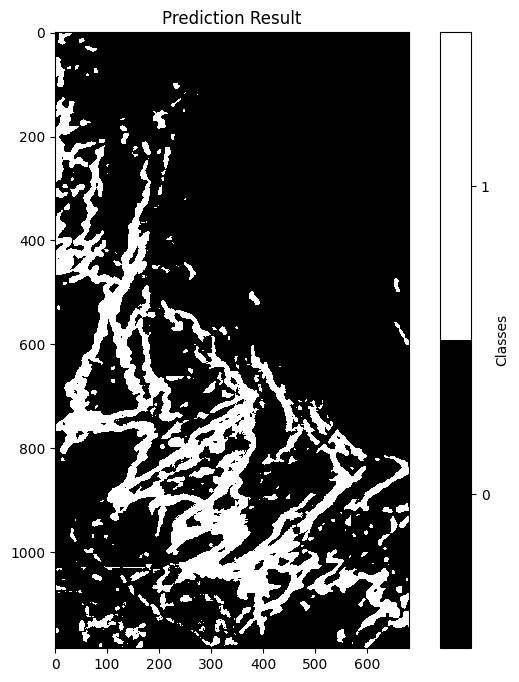

In [13]:
import matplotlib.pyplot as plt
import numpy as nptugas-akhir-model-deteksi-tumpahan-minyakl/simsiam/simsiam/prediction_matrix_dataset10 20250526_132806_model.pth.tar 20250526_134929.npy

# Optional: create a color map (0: black, 1: white, or customize)
cmap = plt.cm.get_cmap('gray', 2)  # 2 discrete colors

plt.figure(figsize=(8, 8))
plt.imshow(pred_matrix, cmap=cmap, interpolation='nearest')
plt.title("Prediction Result")
plt.colorbar(ticks=[0, 1], label="Classes")
plt.clim(-0.5, 1.5)  # Make colorbar more readable
plt.show()
